In [4]:
from VAEs_module import *
import time
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import ipywidgets as pyw
import tkinter.filedialog as tkf
import tifffile
from tabulate import tabulate
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import linalg as LA
import torchvision
import torchvision.transforms as transforms

In [5]:
file_adr = tkf.askopenfilenames()
print(*file_adr, sep="\n")

D:/OneDrive/data_repository/tomography/00000000_L_H3_EELS_tomography/02_STEM_tilt_series/20220313_L_H3_HAADF_tilt_series/aligned_many_c1_r2_100.tif


In [9]:
data_load = load_data(file_adr, dat_dim=4, dat_unit='nm', rescale=False)

(121, 100, 100)


In [11]:
data_load.data_storage[0] = data_load.data_storage[0].reshape(1, 121, 100, 100)
data_load.data_shape[0] = data_load.data_storage[0].shape[:2]

[[50.0, 50.0]]


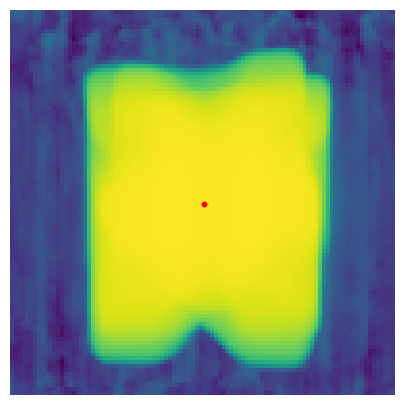

In [15]:
data_load.find_center(cbox_edge=50, center_remove=0, result_visual=True, log_scale=True)

In [16]:
data_load.center_pos[0] = [50.0, 50.0]

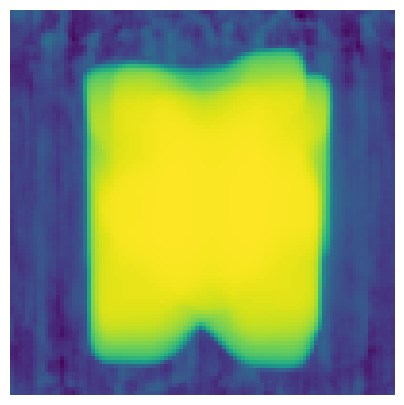

(1, 121, 10000)
(121, 10000)
(121,)
0.0 1.0
1e-06 1.0


In [17]:
data_load.make_input(min_val=1E-6, max_normalize=True, 
           log_scale=False, radial_flat=False, 
           w_size=50, radial_range=None, final_dim=1)

In [ ]:
rand_affine = transforms.Compose([transforms.ToPILImage(),
                                  transforms.RandomAffine(degrees=(-30, 30), translate=(0.05, 0.05)),
                                  transforms.ToTensor()]
                                  )

In [ ]:
num_imgs = len(data_load.dataset_flat)

tmp = []
aug_times = 19
for i in range(aug_times):
    for j in range(num_imgs):
        test = rand_affine(data_load.dataset_flat[j])
        tmp.append(test.squeeze().numpy())
    
tmp = np.asarray(tmp)
print(tmp.shape)
dataset_flat = np.append(data_load.dataset_flat, tmp, axis=0)
print(dataset_flat.shape)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(data_load.dataset_flat[150], cmap="viridis")
ax.axis("off")
plt.show()

In [ ]:
total_num = len(data_load.dataset_flat)
ri = np.random.choice(total_num, total_num, replace=False)

dataset_input = data_load.dataset_flat[ri]

In [ ]:
if torch.cuda.is_available():
    print("%d gpu available"%(torch.cuda.device_count()))
    cuda_device = torch.device("cuda:0")
    print(torch.cuda.get_device_name(cuda_device))
    torch.cuda.set_device(cuda_device)
    print(torch.cuda.memory_summary(device=cuda_device))
else:
    cuda_device = None

In [ ]:
num_comp = 2
channels = [32, 64, 128, 256]
kernels = [4, 4, 4, 4]
padding = [1, 1, 1, 1]
stride = [2, 2, 2, 2]
pooling = [1, 1, 1, 1]

dat_dim = []
tmp_dim = data_load.w_size*2
for i in range(len(kernels)):
    tmp_dim += (-kernels[i]+2*padding[i])
    tmp_dim /= stride[i]
    tmp_dim += 1
    tmp_dim /= pooling[i]
    dat_dim.append(int(tmp_dim))

print(dat_dim)
print(kernels)
print(channels)
print(padding)
print(stride)
print(pooling)

In [ ]:
rotation_check = True
angle_std = np.pi/4
translation_check = True
translation_std = 0.1

parallel_ = True

enc_model = ivVAE2DCNN_encoder(dat_dim[-1], channels, kernels, stride, padding, pooling, 
                                  num_comp, rotation_check, translation_check, translation_std)
if parallel_:
    enc_model = nn.DataParallel(enc_model)
enc_model.cuda(cuda_device)
print(enc_model)

In [ ]:
batch_size = 256
mini_batches = [dataset_input[k:k+batch_size] for k in range(0, len(dataset_input), batch_size)]
print(len(mini_batches))
print(len(mini_batches[-1]))

In [ ]:
grid = np.linspace(1, -1, data_load.w_size*2)
X, Y = np.meshgrid(grid, grid)
img_coord = np.stack([X.ravel(), Y.ravel()], 1)
img_coord = torch.from_numpy(img_coord)
img_coord = img_coord.to(torch.float32)
img_coord = img_coord.requires_grad_(requires_grad=False)
n_dim = img_coord.size(1)
print(img_coord.shape)

In [ ]:
coord = img_coord.expand(batch_size, img_coord.size(0), img_coord.size(1))
coord = coord.requires_grad_(requires_grad=False)
coord = coord.to(cuda_device)
n_coord = coord.size(1)
print(n_coord)
print(coord.shape)

In [ ]:
hid_dim = 512
num_hid = 1
dec_model = ivVAEFCNN_decoder(n_coord, n_dim, num_comp, hid_dim, num_hid, data_load.w_size*2, bi_lin=True)

if parallel_:
    dec_model = nn.DataParallel(dec_model)
    
dec_model.cuda(cuda_device)
print(dec_model)

In [ ]:
n_epoch = 10
l_rate = 0.01
params = list(enc_model.parameters()) + list(dec_model.parameters())
optimizer = optim.Adam(params, lr=l_rate)

In [ ]:
start = time.time()
loss_plot = []
n_fig = 5
for epoch in range(n_epoch):
    loss_epoch = 0
    recon_loss = 0
    KLD_loss = 0
    KLD_rot_loss = 0
    
    latent_z = []
    z_mu = []
    z_logvar = []
    rot_theta = []
    trans_delta = []
    for i, m_batch in enumerate(mini_batches):
        
        x = torch.from_numpy(m_batch).clamp_(min=0.001, max=0.999)
        x = x.to(torch.float32)
        x = x.to(cuda_device)
        x.requires_grad_(requires_grad=False)
        
        tf_coord, mu, logvar, z, rot_mu, rot_logvar, rot_z, trans_z = enc_model(x, coord)
        x_ = dec_model(tf_coord.contiguous(), z)
        
        x_ = x_.view(-1, data_load.w_size*2, data_load.w_size*2)

        reconstruction_error = F.binary_cross_entropy(x_, x, reduction="sum")
        KL_divergence = -0.5*torch.sum(1+logvar-mu**2-logvar.exp())
        KL_divergence_rot = torch.sum(-rot_logvar + np.log(angle_std) + (torch.exp(rot_logvar)**2 + 
                                                              rot_mu**2)/2/angle_std**2 - 0.5)
        
        loss = reconstruction_error + KL_divergence + KL_divergence_rot
        
        loss_epoch += loss.item()
        recon_loss += reconstruction_error.item()
        KLD_loss += KL_divergence.item()
        KLD_rot_loss += KL_divergence_rot.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        latent_z.extend(z.data.cpu().numpy().tolist())
        z_mu.extend(mu.data.cpu().numpy().tolist())
        z_logvar.extend(logvar.data.cpu().numpy().tolist())
        rot_theta.extend(rot_z.data.cpu().numpy().tolist())
        if translation_check:
            trans_delta.extend(trans_z.data.cpu().numpy().tolist())
    
    loss_plot.append(loss_epoch/data_load.total_num)
    
    latent_z = np.asarray(latent_z)
    z_mu = np.asarray(z_mu)
    z_logvar = np.asarray(z_logvar)
    rot_theta = np.asarray(rot_theta)
    trans_delta = np.asarray(trans_delta)
            
            
    if epoch == 0:
        print(torch.cuda.memory_summary(device=cuda_device))
        
    if (epoch+1) % int(n_epoch/10) == 0:
        fig, ax = plt.subplots(1, 1)
        ax.plot(np.arange(epoch+1)+1, loss_plot, "k-")
        ax.grid()
        plt.show()
        
        print(tabulate([
                        ["epoch", epoch+1], 
                        ["total loss", loss_epoch/data_load.total_num],
                        ["reconstruction error", recon_loss/data_load.total_num],
                        ["KL divergence", KLD_loss/data_load.total_num],
                        ["KL divergence (rotation)", KLD_rot_loss/data_load.total_num],
                        ]))
        print("%.2f minutes have passed"%((time.time()-start)/60))
        
        fig, ax = plt.subplots(2, n_fig, figsize=(5*n_fig, 5*2))
        for i in range(n_fig):
            ax[0][i].imshow(x[i].data.cpu().numpy().astype(np.float32), cmap="inferno")
            ax[1][i].imshow(x_[i].data.cpu().numpy().astype(np.float32), cmap="inferno")
        fig.tight_layout()
        plt.show()

        coeffs = np.zeros_like(latent_z)
        coeffs[data_load.ri] = latent_z.copy()
        coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)  
        
        fig, ax = plt.subplots(1, 1)
        ax.grid()
        for i in range(num_comp):
            ax.hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))
        plt.show()

        if data_load.num_img != 1:
            for i in range(num_comp):
                fig, ax = plt.subplots(1, num_img, figsize=(7*data_load.num_img, 7))
                for j in range(num_img):
                    tmp = ax[j].imshow(coeffs_reshape[j][:, :, i], cmap="viridis")
                    ax[j].axis("off")
                    #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
                plt.show()
        else:            
            for i in range(num_comp):
                fig, ax = plt.subplots(1, 1, figsize=(7, 7*data_load.num_img))
                tmp = ax.imshow(coeffs_reshape[0][:, :, i], cmap="viridis")
                ax.axis("off")
                #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
                plt.show()

print("The training has been finished.")

In [ ]:
coeffs = np.zeros_like(latent_z)
coeffs[data_load.ri] = latent_z.copy()
coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)

fig, ax = plt.subplots(1, 1)
ax.grid()
for i in range(num_comp):
    ax.hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))
plt.show()

if data_load.num_img != 1:
    for i in range(num_comp):
        fig, ax = plt.subplots(1, num_img, figsize=(7*data_load.num_img, 7))
        for j in range(num_img):
            tmp = ax[j].imshow(coeffs_reshape[j][:, :, i], cmap="viridis")
            ax[j].axis("off")
            #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
        plt.show()
else:            
    for i in range(num_comp):
        fig, ax = plt.subplots(1, 1, figsize=(7, 7*data_load.num_img))
        tmp = ax.imshow(coeffs_reshape[0][:, :, i], cmap="viridis")
        ax.axis("off")
        #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
        plt.show()

In [ ]:
if rotation_check:
    rot_theta = np.expand_dims(rot_theta, axis=1)
    coeffs = np.zeros_like(rot_theta)
    coeffs[data_load.ri] = rot_theta.copy()
    coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)

    fig, ax = plt.subplots(1, 1)
    ax.grid()
    ax.hist(coeffs[:], bins=50, alpha=(1.0-i*(1/num_comp)))
    plt.show()

    if data_load.num_img != 1:
        fig, ax = plt.subplots(1, num_img, figsize=(7*data_load.num_img, 7))
        for j in range(num_img):
            tmp = ax[j].imshow(coeffs_reshape[j][:, :], cmap="viridis")
            ax[j].axis("off")
            #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
        plt.show()
    else:            
        fig, ax = plt.subplots(1, 1, figsize=(7, 7*data_load.num_img))
        tmp = ax.imshow(coeffs_reshape[0][:, :], cmap="viridis")
        ax.axis("off")
        #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
        plt.show()

In [ ]:
if translation_check:
    coeffs = np.zeros_like(trans_delta)
    coeffs[data_load.ri] = trans_delta.copy()
    coeffs_reshape = reshape_coeff(coeffs, data_load.data_shape)

    fig, ax = plt.subplots(1, 1)
    ax.grid()
    for i in range(2):
        ax.hist(coeffs[:, i], bins=50, alpha=(1.0-i*(1/num_comp)))
    plt.show()

    if data_load.num_img != 1:
        for i in range(2):
            fig, ax = plt.subplots(1, num_img, figsize=(7*data_load.num_img, 7))
            for j in range(num_img):
                tmp = ax[j].imshow(coeffs_reshape[j][:, :, i], cmap="viridis")
                ax[j].axis("off")
                #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
            plt.show()
    else:            
        for i in range(2):
            fig, ax = plt.subplots(1, 1, figsize=(7, 7*data_load.num_img))
            tmp = ax.imshow(coeffs_reshape[0][:, :, i], cmap="viridis")
            ax.axis("off")
            #fig.colorbar(tmp, cax=fig.add_axes([0.92, 0.15, 0.04, 0.7]))
            plt.show()

In [ ]:
n_sample = 20
sigma = 5.0
z_test = np.linspace(-sigma, sigma, n_sample*10, endpoint=True)
rv = stats.norm(0, 1)
norm_pdf = rv.pdf(z_test)
norm_pdf = norm_pdf / np.sum(norm_pdf)
z_test = np.sort(np.random.choice(z_test, n_sample, replace=False, p=norm_pdf))
z_test = np.meshgrid(z_test, z_test)
z_test = np.stack((z_test[0].flatten(), z_test[1].flatten()), axis=1)
print(z_test.shape)
z_test = torch.from_numpy(z_test).to(torch.float32).to(cuda_device)

coord_test = img_coord.expand(n_sample**2, img_coord.size(0), img_coord.size(1))
coord_test = coord_test.to(cuda_device)
print(coord_test.shape)

In [ ]:
dec_model.eval()
generated = dec_model(coord_test.contiguous(), z_test)
print(generated.shape)
generated = generated.view(n_sample**2, data_load.w_size*2, data_load.w_size*2)
print(generated.shape)

In [ ]:
fig, ax = plt.subplots(n_sample, n_sample, figsize=(30, 30))
for i, a in enumerate(ax.flat):
    a.imshow(generated[i].squeeze().data.cpu().numpy().astype(np.float32), cmap="jet")
    a.axis("off")
plt.subplots_adjust(hspace=0.01, wspace=0.01)
plt.show()